In [ ]:
import pandas as pd
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, cohen_kappa_score, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import textstatistics
from nltk.tokenize import word_tokenize
import torch
from transformers import BertTokenizer, BertModel
import re
import pickle
import optuna
from sklearn.metrics import cohen_kappa_score

In [ ]:
# Download stopwords
nltk.download('stopwords')

columns_to_read = ['full_text', 'score']

# Load data
dataset = pd.read_csv('train.csv', usecols=columns_to_read)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Training XGBoost Algorithm:

In [ ]:
def train_xgb(X, y):

    #Data Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Convert to DMatrix, the data structure used by XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set XGBoost parameters for classification
    params = {
        'max_depth': 6,
        'eta': 0.3,
        'objective': 'multi:softmax',  # For classification
        'num_class': len(y.unique())  # Number of classes
    }
    num_rounds = 100

    # Train the model
    bst = xgb.train(params, dtrain, num_rounds)

    # Predict
    y_pred = bst.predict(dtest)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    print(f'Accuracy: {accuracy}')

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(len(dataset['score'].unique())))

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Quadratic Weighted Kappa (QWK): {qwk:.2f}")

# Preprocessing text:

In [ ]:
def preprocess_text(text):
    tokens = gensim.utils.simple_preprocess(text)
    return tokens

In [ ]:
def clean_text(text):
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [ ]:
# Apply preprocessing
dataset['tokens'] = dataset['full_text'].apply(preprocess_text)

# Clean the text
dataset['clean_text'] = dataset['full_text'].apply(clean_text)

# Convert scores to zero-indexed categorical labels (assuming scores are integers starting from 1)
dataset['score'] = dataset['score'] - 1

# Doc2Vec Model:

In [ ]:
# Prepare data for doc2vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset['tokens'])]

# Train doc2vec model
doc2vec_model = Doc2Vec(documents, vector_size=200, window=5, min_count=2, workers=4, epochs=40)

# Get vectors for each essay
dataset['doc2vec_vectors'] = dataset['tokens'].apply(lambda x: doc2vec_model.infer_vector(x))


In [ ]:
dataset['doc2vec_vectors'][0]

array([-0.11714725,  1.79456   , -0.04467436, -0.6375069 ,  0.29677132,
        1.2874424 , -1.6350288 ,  0.9038059 ,  2.3899486 ,  0.5959704 ,
        0.4053697 ,  2.3114667 ,  1.8504015 , -0.7764172 , -0.17586395,
       -1.2027317 , -1.0645007 ,  0.11517528, -0.27564704,  1.5063958 ,
        0.3757148 , -0.16795765, -0.5705796 , -0.58788776, -0.9526201 ,
       -0.85175365, -1.363986  ,  0.39096302, -1.8424537 ,  0.34812993,
       -0.04021628,  0.7493284 ,  0.85571784, -0.01588812,  1.1932147 ,
       -1.0276637 ,  0.40243405, -1.567982  , -2.353027  ,  0.78099597,
        0.91794276,  1.4352541 ,  0.81104773, -1.7079159 ,  1.1277283 ,
        0.42883086, -0.91976976, -2.767011  ,  0.5581851 ,  0.38624108,
        0.26491874,  0.65031594, -0.9009439 ,  0.63890743,  1.247106  ,
       -1.4295553 ,  0.24119668, -0.47965205, -1.9409872 , -2.9360976 ,
        0.37583992, -0.19810998, -1.0895202 , -0.04726233,  0.9145441 ,
        0.05144741, -1.3943187 , -0.8139822 ,  0.9184727 ,  1.40

In [ ]:
len(dataset['doc2vec_vectors'][0])

200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4708261120739457


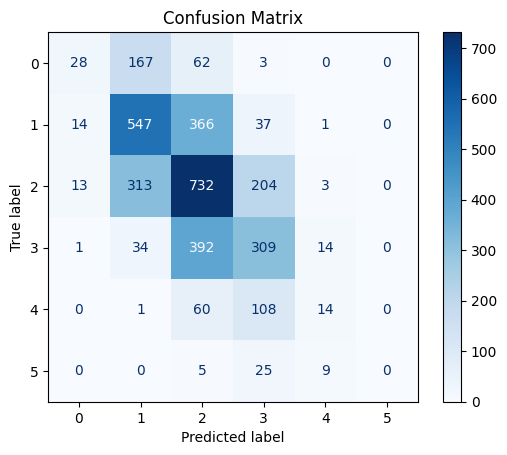

Precision: 0.46
Recall: 0.47
Quadratic Weighted Kappa (QWK): 0.56


In [ ]:
# Split data
X = list(dataset['doc2vec_vectors'])
y = dataset['score']
train_xgb(X, y)

# Word2Vec Model:

In [ ]:
word_2_vec = Word2Vec(dataset['tokens'], sg=1)

# Create Document Embeddings
def document_embedding(tokens, model):
    # Filter tokens that are in the vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

dataset['word2vec_embedding'] = dataset['tokens'].apply(lambda x: document_embedding(x, word_2_vec))


In [ ]:
word_2_vec.wv['time']

array([ 0.25274134,  0.18769345,  0.08349447,  0.06744717,  0.28375033,
       -0.3408363 ,  0.16064724,  0.24266607,  0.14565237,  0.34247023,
        0.01602339, -0.17632957,  0.00093384,  0.03165566, -0.05616685,
        0.06899133,  0.28158987, -0.25969025, -0.32758668, -0.1941615 ,
        0.05905569, -0.03055902, -0.06799177, -0.54200494, -0.00383681,
        0.03621334, -0.07067064, -0.01389722,  0.18646692,  0.08788975,
        0.31150576, -0.23996587, -0.15664358, -0.1628659 , -0.23480265,
        0.02224499, -0.05175745, -0.3872897 , -0.02353954, -0.5229504 ,
       -0.0850169 , -0.34760383, -0.19575667,  0.1816296 ,  0.25739267,
       -0.01907638,  0.01848448,  0.20356524,  0.5294125 ,  0.11283548,
       -0.43017295,  0.16568692,  0.12170821,  0.19095145,  0.19390008,
        0.05737608, -0.3859826 ,  0.25659093,  0.04760768, -0.12257092,
        0.23867889,  0.29723704, -0.10325865,  0.09762042,  0.00445161,
        0.65431684,  0.15837407,  0.07139716, -0.7699537 ,  0.08

In [ ]:
word_2_vec.wv.most_similar('time')

[('roadtrips', 0.6098679304122925),
 ('extended', 0.6070204377174377),
 ('hvae', 0.5782170295715332),
 ('spen', 0.5746702551841736),
 ('availble', 0.5709627270698547),
 ('pen', 0.5702911019325256),
 ('periods', 0.5699548125267029),
 ('tireing', 0.5648030042648315),
 ('ecspecially', 0.5616020560264587),
 ('privilage', 0.5599392652511597)]

In [ ]:
word_2_vec.wv.most_similar('technology')

[('techonology', 0.8965651392936707),
 ('technolgy', 0.8861696124076843),
 ('techology', 0.8541069626808167),
 ('techonolgy', 0.8411253690719604),
 ('tecnology', 0.8377337455749512),
 ('techonlogy', 0.8260040283203125),
 ('tehnology', 0.8129680156707764),
 ('technoloy', 0.7883874773979187),
 ('tehcnology', 0.7825776934623718),
 ('technologly', 0.7692978382110596)]

Accuracy: 0.44280762564991333


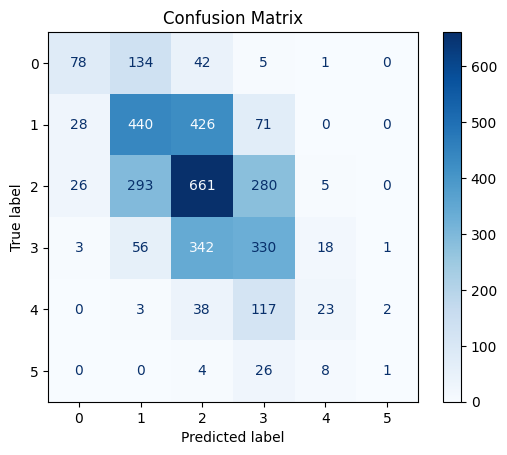

Precision: 0.45
Recall: 0.44
Quadratic Weighted Kappa (QWK): 0.55


In [ ]:
X = list(dataset['word2vec_embedding'])
y = dataset['score']
train_xgb(X, y)

In [ ]:
dataset

,full_text,score,tokens,bert_vectors,doc2vec_vectors,word2vec_embedding
0,Many people have car where they live. The thin...,2,"[many, people, car, live, thing, know, use, ca...","[[-0.4510786, -0.61312973, -0.9915619, 0.58666...","[-0.6013362, 1.5564349, -0.21694282, 2.4798417...","[0.09868326, 0.14937146, 0.110611595, -0.18116..."
1,I am a scientist at NASA that is discussing th...,2,"[scientist, nasa, discussing, face, mars, expl...","[[-0.44012108, -0.6400353, -0.9984654, 0.58960...","[-0.69213426, 0.16976108, -2.006672, -0.322937...","[0.030908925, -0.09713067, -0.079285726, 0.044..."
2,People always wish they had the same technolog...,3,"[people, always, wish, technology, seen, movie...","[[-0.6941047, -0.70088804, -0.9976579, 0.69354...","[-1.546322, -0.44449148, -1.0853112, -1.565009...","[-0.019957826, 0.07348071, 0.112887084, -0.063..."
3,"We all heard about Venus, the planet without a...",3,"[heard, venus, planet, without, almost, oxygen...","[[-0.47142595, -0.58093745, -0.96070683, 0.292...","[-0.11000004, 2.1037993, -1.0489368, 1.3590332...","[-0.056483038, -0.07229383, 0.19571419, -0.022..."
4,"Dear, State Senator\n\nThis is a letter to arg...",2,"[dear, state, senator, letter, argue, favor, k...","[[-0.9814893, -0.92573893, -0.99992716, 0.9851...","[-0.17245847, 0.9834995, 0.35512155, -0.506286...","[0.061799444, 0.43143573, 0.1636162, -0.347826..."
...,...,...,...,...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",1,"[story, challenge, exploing, venus, informativ...","[[-0.10388627, -0.24056004, -0.97392523, 0.198...","[-0.87323844, 0.096253194, -0.33556357, 0.9219...","[-0.03451544, -0.01714574, 0.102099076, -0.016..."
17303,Technology has changed a lot of ways that we l...,3,"[technology, changed, lot, ways, live, today, ...","[[-0.4643471, -0.47675395, -0.9489571, 0.28652...","[1.1509988, -0.1555144, 2.0368912, 2.6971693, ...","[0.03379165, -0.107506886, 0.18613574, -0.0333..."
17304,If you don't like sitting around all day than ...,1,"[like, sitting, around, day, great, opportunit...","[[-0.6860596, -0.6364956, -0.997904, 0.7050073...","[0.25191867, 0.6329397, -1.6539253, -0.0470355...","[0.0991198, -0.004911612, 0.08610494, -0.04291..."
17305,"In ""The Challenge of Exporing Venus,"" the auth...",0,"[challenge, exporing, venus, author, suggests,...","[[-0.55692744, -0.58910525, -0.9882614, 0.3367...","[0.02642863, 0.24310982, -0.50016785, -0.13005...","[-0.046185847, -0.13309696, 0.2500523, -0.0397..."


# LDA Model:

In [ ]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(dataset['tokens'])
corpus = [dictionary.doc2bow(text) for text in dataset['tokens']]

# Train LDA model
num_topics = 500  # Adjust the number of topics as needed
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Function to get topic distribution for a document
def get_topic_distribution(lda_model, corpus, num_topics):
    topics = lda_model.get_document_topics(corpus, minimum_probability=0)
    topic_matrix = np.zeros((len(corpus), num_topics))
    for i, topic_dist in enumerate(topics):
        for topic, prob in topic_dist:
            topic_matrix[i][topic] = prob
    return topic_matrix

# Generate document-topic vectors
topic_vectors = get_topic_distribution(lda_model, corpus, num_topics)
dataset['lda_vectors'] = list(topic_vectors)

# Ensure all document vectors are valid (remove any NaN vectors)
dataset = dataset.dropna(subset=['lda_vectors'])


In [ ]:
dataset['lda_vectors'][0]

array([4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.99042347e-02, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       1.03608385e-01, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
       4.28653129e-06, 4.28653129e-06, 4.28653129e-06, 4.28653129e-06,
      

In [ ]:
len(dataset['lda_vectors'][100])

500

Accuracy: 0.5924321201617562


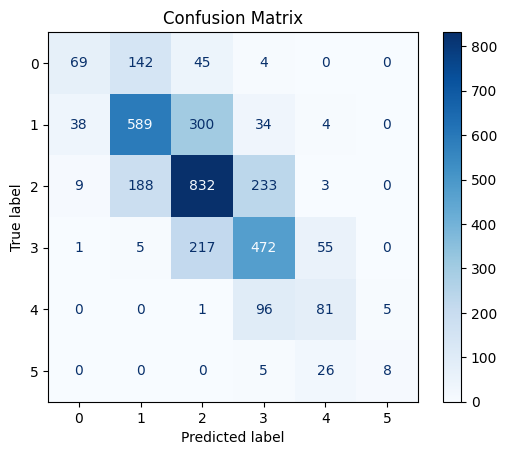

Precision: 0.59
Recall: 0.59
Quadratic Weighted Kappa (QWK): 0.74


In [ ]:
X = np.array(list(dataset['lda_vectors']))
y = dataset['score']
train_xgb(X, y)

# BERT Model:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    encoded_batch = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_batch)
        batch_embeddings = output.pooler_output
    return batch_embeddings.cpu().numpy()
dataset['bert_vectors'] = dataset.full_text.apply(get_bert_embeddings)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
dataset

,full_text,score,tokens,bert_vectors
0,Many people have car where they live. The thin...,2,"[many, people, car, live, thing, know, use, ca...","[[-0.4510786, -0.61312973, -0.9915619, 0.58666..."
1,I am a scientist at NASA that is discussing th...,2,"[scientist, nasa, discussing, face, mars, expl...","[[-0.44012108, -0.6400353, -0.9984654, 0.58960..."
2,People always wish they had the same technolog...,3,"[people, always, wish, technology, seen, movie...","[[-0.6941047, -0.70088804, -0.9976579, 0.69354..."
3,"We all heard about Venus, the planet without a...",3,"[heard, venus, planet, without, almost, oxygen...","[[-0.47142595, -0.58093745, -0.96070683, 0.292..."
4,"Dear, State Senator\n\nThis is a letter to arg...",2,"[dear, state, senator, letter, argue, favor, k...","[[-0.9814893, -0.92573893, -0.99992716, 0.9851..."
...,...,...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",1,"[story, challenge, exploing, venus, informativ...","[[-0.10388627, -0.24056004, -0.97392523, 0.198..."
17303,Technology has changed a lot of ways that we l...,3,"[technology, changed, lot, ways, live, today, ...","[[-0.4643471, -0.47675395, -0.9489571, 0.28652..."
17304,If you don't like sitting around all day than ...,1,"[like, sitting, around, day, great, opportunit...","[[-0.6860596, -0.6364956, -0.997904, 0.7050073..."
17305,"In ""The Challenge of Exporing Venus,"" the auth...",0,"[challenge, exporing, venus, author, suggests,...","[[-0.55692744, -0.58910525, -0.9882614, 0.3367..."


In [ ]:
bert_embeddings = np.vstack(dataset['bert_vectors'].values)

In [ ]:
len(bert_embeddings[0])

768

Accuracy: 0.5271519352975159


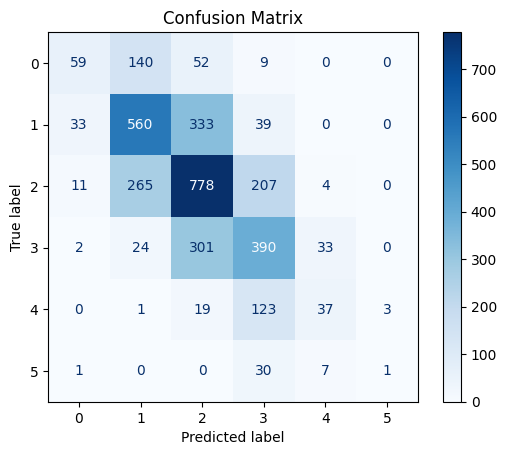

Precision: 0.52
Recall: 0.53
Quadratic Weighted Kappa (QWK): 0.64


In [ ]:
X = pd.DataFrame(bert_embeddings)
y = dataset['score']
train_xgb(X, y)


## TF-IDF:

In [ ]:
# Generate TF-IDF embeddings for the cleaned_text column
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_embeddings = tfidf_vectorizer.fit_transform(dataset['clean_text'])


Accuracy: 0.5407279029462738


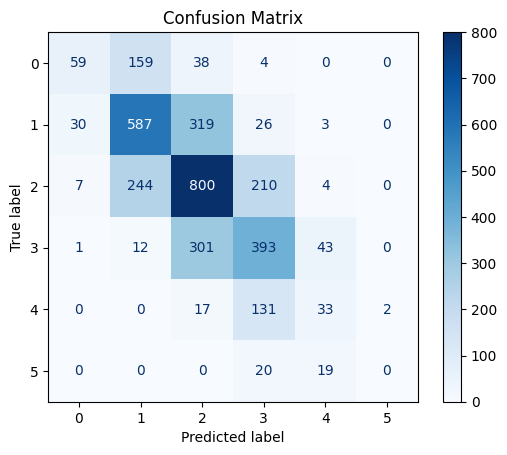

Precision: 0.53
Recall: 0.54
Quadratic Weighted Kappa (QWK): 0.68


In [ ]:
# Use the sparse matrix directly
X = tfidf_embeddings
y = dataset['score']
train_xgb(X, y)

In [ ]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(dataset['tokens'])
corpus = [dictionary.doc2bow(text) for text in dataset['tokens']]

# Function to train LDA model and return QWK score
def objective(trial):
    num_topics = trial.suggest_int('num_topics', 50, 300)
    passes = trial.suggest_int('passes', 10, 30)
    iterations = trial.suggest_int('iterations', 50, 300)
    alpha = trial.suggest_categorical('alpha', ['symmetric', 'asymmetric', 'auto'])
    eta = trial.suggest_categorical('eta', ['symmetric', 'auto'])
    chunksize = trial.suggest_int('chunksize', 500, 5000)

    lda_model = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=passes,
        iterations=iterations,
        alpha=alpha,
        eta=eta,
        chunksize=chunksize,
        random_state=42
    )

    # Generate document-topic vectors
    topic_vectors = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])
    topic_vectors = np.array([[prob for _, prob in doc] for doc in topic_vectors])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(topic_vectors, dataset['score'], test_size=0.2, random_state=42)

    # Train a classifier on the LDA topic vectors using XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
        'objective': 'multi:softmax',
        'num_class': len(set(dataset['score'])),
        'eval_metric': 'mlogloss',
        'tree_method': 'gpu_hist',  # Use GPU for training
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True)
    }

    bst = xgb.train(param, dtrain, num_boost_round=100)

    # Predict on the test set
    y_pred = bst.predict(dtest)

    # Calculate QWK score
    qwk_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')

    return qwk_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final LDA model with the best hyperparameters
lda_model = LdaModel(
    corpus=corpus,
    num_topics=best_params['num_topics'],
    id2word=dictionary,
    passes=best_params['passes'],
    iterations=best_params['iterations'],
    alpha=best_params['alpha'],
    eta=best_params['eta'],
    chunksize=best_params['chunksize'],
    random_state=42
)

# Function to get topic distribution for a document
def get_topic_distribution(lda_model, corpus, num_topics):
    topics = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]
    topic_matrix = np.zeros((len(corpus), num_topics))
    for i, topic_dist in enumerate(topics):
        for topic, prob in topic_dist:
            topic_matrix[i][topic] = prob
    return topic_matrix

# Generate document-topic vectors
num_topics = best_params['num_topics']
topic_vectors = get_topic_distribution(lda_model, corpus, num_topics)
dataset['lda_vectors'] = list(topic_vectors)

# Ensure all document vectors are valid (remove any NaN vectors)
dataset = dataset.dropna(subset=['lda_vectors'])


[I 2024-07-01 05:59:36,063] A new study created in memory with name: no-name-dbafd3d2-1e37-4116-888d-107dfda466b1


In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import gensim
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
dataset = pd.read_csv('trains.csv', encoding='latin1')

# Explore the dataset
print(dataset.head())
print(dataset.info())

# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove non-alphabetical characters and tokenize the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = gensim.utils.simple_preprocess(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

dataset['tokens'] = dataset['full_text'].apply(preprocess_text)

# Convert scores to zero-indexed categorical labels (assuming scores are integers starting from 1)
dataset['score'] = dataset['score'] - 1

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(dataset['tokens'])
corpus = [dictionary.doc2bow(text) for text in dataset['tokens']]

# Train LDA model with more topics and passes
num_topics = 50  # Increase the number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)  # Increase the number of passes




# Function to get topic distribution for a document
def get_topic_distribution(lda_model, corpus, num_topics):
    topics = lda_model.get_document_topics(corpus, minimum_probability=0)
    topic_matrix = np.zeros((len(corpus), num_topics))
    for i, topic_dist in enumerate(topics):
        for topic, prob in topic_dist:
            topic_matrix[i][topic] = prob
    return topic_matrix

# Generate document-topic vectors
topic_vectors = get_topic_distribution(lda_model, corpus, num_topics)
dataset['lda_vectors'] = list(topic_vectors)

# Ensure all document vectors are valid (remove any NaN vectors)
dataset = dataset.dropna(subset=['lda_vectors'])

# TF-IDF Vectorizer with bigrams
tfidf = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))
tfidf_vectors = tfidf.fit_transform(dataset['full_text'])

# Combine LDA and TF-IDF vectors
combined_vectors = np.hstack([list(dataset['lda_vectors']), tfidf_vectors.toarray()])

X = combined_vectors
y = dataset['score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


  essay_id                                          full_text  score
0  000d118  Many people have car where they live. The thin...      3
1  000fe60  I am a scientist at NASA that is discussing th...      3
2  001ab80  People always wish they had the same technolog...      4
3  001bdc0  We all heard about Venus, the planet without a...      4
4  002ba53  Dear, State Senator\n\nThis is a letter to arg...      3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB
None


In [ ]:
# Set the hyperparameters manually with more tuning
params = {
    'max_depth': 10,
    'eta': 0.01,
    'objective': 'multi:softmax',
    'num_class': len(y.unique()),
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'lambda': 1.5,
    'alpha': 0.5,
    'n_estimators': 500  # Increase number of boosting rounds
}

# Train the model using GridSearchCV
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)
parameters = {
    'max_depth': [6, 8, 10],
    'eta': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'lambda': [1, 1.5, 2],
    'alpha': [0, 0.5, 1],
    'n_estimators': [100, 200, 500]
}

clf = GridSearchCV(xgb_model, parameters, scoring='accuracy', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(len(dataset['score'].unique())))

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Quadratic Weighted Kappa (QWK): {qwk:.2f}')